# This notebook tests the Nested Unet segmentation model

Make sure to have the follwing file paths:  
krevera_synthetic_dataset.py   
krevera_project_segment.py  
NestedUnet_Segmentation_best.pth  
./krevera_synthetic_dataset_test  



In [25]:

import torch
import numpy as np
import zipfile
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import krevera_synthetic_dataset # Might need to adjust import path
import json
from tqdm import tqdm
import torch.nn as nn

import importlib
importlib.reload(krevera_synthetic_dataset)
from krevera_synthetic_dataset import KreveraSyntheticDataset
from torchvision import models
import torch.nn.functional as F

from krevera_project_segment import NestedUNet # Might need to adjust import path


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
num_workers = os.cpu_count()
print(num_workers)

cuda
32


In [26]:
# Model

model = NestedUNet(num_classes=3, input_channels=3, deep_supervision=False)
model.load_state_dict(torch.load('NestedUnet_Segmentation_best.pth')) # Path to model state dict
print(model)

NestedUNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up): Upsample(scale_factor=2.0, mode='bilinear')
  (conv0_0): VGGBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (SE): Squeeze_Excite(
      (avgpool): AdaptiveAvgPool2d(output_size=1)
      (fc): Sequential(
        (0): Linear(in_features=32, out_features=4, bias=False)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=4, out_features=32, bias=False)
        (3): Sigmoid()
      )
    )
  )
  (conv1_0): VGGBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(6

In [27]:
def inference(datapoint, model, device):
    model.eval()
    model.to(device)
    with torch.no_grad():
        views = datapoint['input_rgb']
        target_segmentation = datapoint['target_segmentation']
        views = views.to(device)
        outputs = model(views)
        
        predicted_segmentation = torch.argmax(outputs, dim=1)
         # Visualize data
        mean = np.array([0.4016, 0.3994, 0.4520])
        std = np.array([0.2425, 0.2206, 0.1979])
        fig, axs = plt.subplots(5, 3, figsize=(15, 25))  # Prepare subplots for 5 data points
        colors = ['black', 'white', 'red']
        cmap = ListedColormap(colors)

        for i in range(5):
            # Normalize and display the input images
            img = views[i].cpu().permute(1, 2, 0).numpy() * std + mean
            axs[i, 0].imshow(img)
            axs[i, 0].axis('off')
            axs[i, 0].set_title('Input Image')

            # Display the ground truth segmentation
            ground_truth = torch.argmax(datapoint['target_segmentation'], dim=1)[i].cpu().numpy()
            axs[i, 1].imshow(ground_truth, cmap=cmap, vmin=0, vmax=2)
            axs[i, 1].axis('off')
            axs[i, 1].set_title('Ground Truth')

            # Display the predicted segmentation
            prediction = predicted_segmentation[i].cpu().numpy()
            axs[i, 2].imshow(prediction, cmap=cmap, vmin=0, vmax=2)
            axs[i, 2].axis('off')
            axs[i, 2].set_title('Predicted Segmentation')

        plt.show()

        

        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


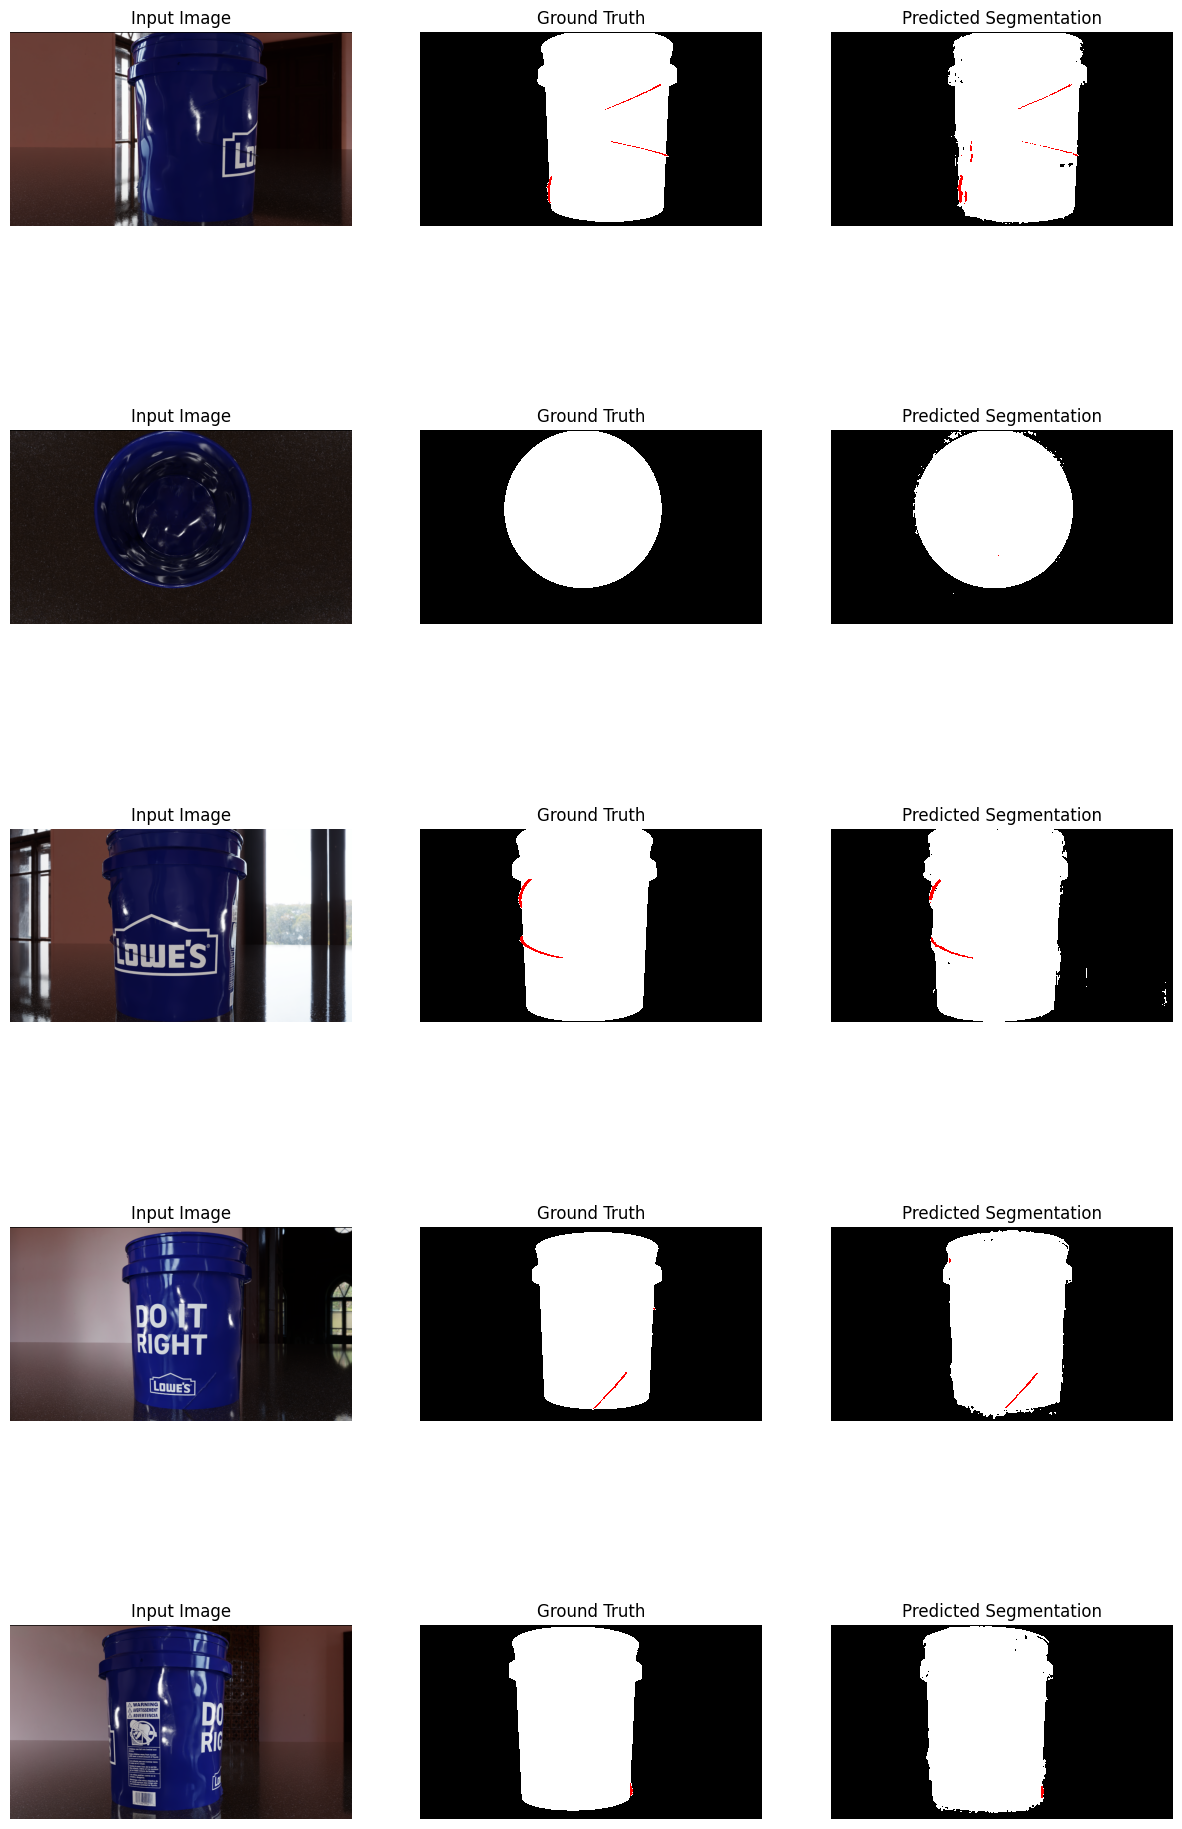

In [30]:
test_dataset = KreveraSyntheticDataset("./krevera_synthetic_dataset_test", #Path to test dataset
                                    zero_one_normalize=True, 
                                    is_train=False
                                    )
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False,  drop_last=True, num_workers=32)

datapoint = test_dataset[6]
inference(datapoint, model, device)

In [24]:
total_flash_pixels_per_image_gt = []
total_flash_pixels_per_image_pred = []

def dice_score_and_iou(preds, targets, smooth=1e-6, exclude_top=False):
    if exclude_top:
        preds = torch.cat([preds[:1], preds[2:]], dim=0)
        targets = torch.cat([targets[:1], targets[2:]], dim=0)

    preds = torch.softmax(preds, dim=1)
    preds_one_hot = torch.zeros_like(preds).scatter_(1, preds.argmax(1, keepdim=True), 1)
    for image in range(targets.shape[0]):
        total_flash_pixels_per_image_gt.append(torch.sum(targets[image][2]).item())
        total_flash_pixels_per_image_pred.append(torch.sum(preds_one_hot[image][2]).item())
    # Calculate intersection and cardinality for Dice score
    intersection = torch.sum(preds_one_hot * targets, dim=(2, 3))
    cardinality = torch.sum(preds_one_hot + targets, dim=(2, 3))
    
    dice = (2. * intersection + smooth) / (cardinality + smooth)
    dice_score_per_class = dice.mean(dim=0)

    # Calculate IoU
    union = cardinality - intersection
    iou = (intersection + smooth) / (union + smooth)
    iou_score_per_class = iou.mean(dim=0)

    return dice_score_per_class, iou_score_per_class

#calculate dice score on test set
model.eval()
i=0
with torch.no_grad():
    test_dice_background = 0.0
    test_dice_bucket = 0.0
    test_dice_flash = 0.0
    iou_flash = 0.0
    for batch in test_loader:
        i+=1
        print(i)
        input_rgbs = batch["input_rgb"].to(device)
        input_rgbs = input_rgbs.view(input_rgbs.shape[0]*input_rgbs.shape[1],input_rgbs.shape[2],input_rgbs.shape[3],input_rgbs.shape[4])
        target_masks = batch["target_segmentation"].to(device)
        target_masks = target_masks.view(target_masks.shape[0]*target_masks.shape[1],target_masks.shape[2],target_masks.shape[3],target_masks.shape[4])
        outputs = model(input_rgbs)
        dice_score_per_class, iou_score_per_class = dice_score_and_iou(outputs, target_masks, exclude_top=True)
        test_dice_background += dice_score_per_class[0].item()
        test_dice_bucket += dice_score_per_class[1].item()
        test_dice_flash += dice_score_per_class[2].item()
        iou_flash += iou_score_per_class[2].item()

    test_dice_background /= len(test_loader)
    test_dice_bucket /= len(test_loader)
    test_dice_flash /= len(test_loader)
    iou_flash /= len(test_loader)

print(f"Test Dice Score Background: {test_dice_background}")
print(f"Test Dice Score Bucket: {test_dice_bucket}")
print(f"Test Dice Score Flash: {test_dice_flash}")
print(f"Test IoU Flash: {iou_flash}")

/home/exouser/miniconda3/envs/krevera_env/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/exouser/miniconda3/envs/krevera_env/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change f

1


/home/exouser/miniconda3/envs/krevera_env/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Test Dice Score Background: 0.9901601732379258
Test Dice Score Bucket: 0.9784996912936972
Test Dice Score Flash: 0.6667855767711952
Test IoU Flash: 0.6067000140266693


In [7]:
print(total_flash_pixels_per_image_gt)
print(total_flash_pixels_per_image_pred)

[1167.0, 132.0, 0.0, 348.0, 56.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.0, 1583.0, 12.0, 1226.0, 1701.0, 0.0, 193.0, 1684.0, 510.0, 0.0, 0.0, 112.0, 53.0, 221.0, 0.0, 70.0, 355.0, 0.0, 57.0, 1230.0, 0.0, 1415.0, 491.0, 189.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1033.0, 0.0, 196.0, 699.0, 614.0, 897.0, 0.0, 565.0, 476.0, 601.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1650.0, 0.0, 1189.0, 789.0, 831.0, 455.0, 0.0, 729.0, 0.0, 464.0, 160.0, 0.0, 0.0, 319.0, 0.0, 0.0, 0.0, 1192.0, 865.0, 2003.0, 0.0, 0.0, 0.0, 0.0, 0.0, 665.0, 0.0, 119.0, 852.0, 0.0, 623.0, 0.0, 356.0, 509.0, 67.0, 564.0, 0.0, 0.0, 418.0, 0.0, 0.0, 0.0, 2314.0, 718.0, 1682.0, 1964.0, 0.0, 320.0, 1631.0, 316.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 628.0, 0.0, 670.0, 0.0, 0.0, 1396.0, 89.0, 1390.0, 0.0, 0.0, 487.0, 150.0, 240.0, 1266.0, 920.0, 0.0, 0.0, 400.0, 170.0, 719.0, 0.0, 0.0, 107.0, 214.0, 259.0, 157.0, 54.0, 728.0, 0.0, 681.0, 0.0, 63.0, 0.0, 475.0, 392.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1191.0, 0.0, 1196.0, 0.0, 0.

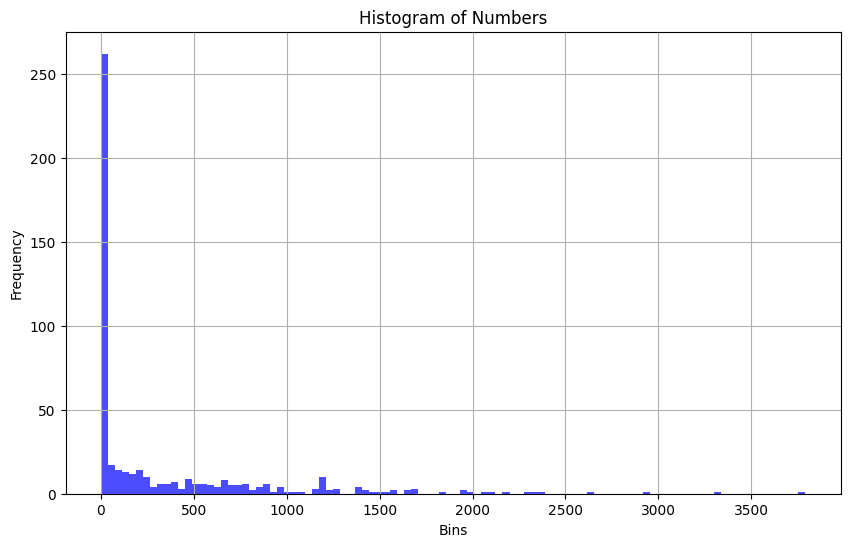

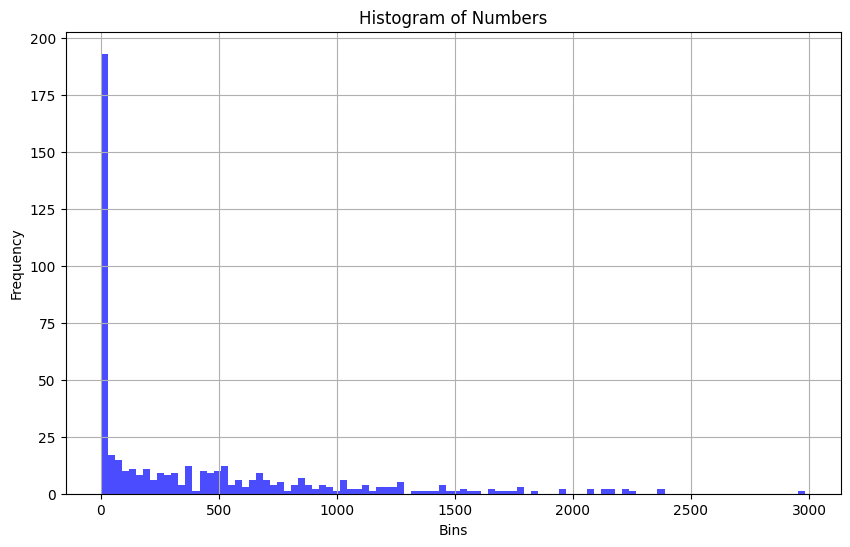

In [11]:
import matplotlib.pyplot as plt

def plot_histogram(x):
    plt.figure(figsize=(10, 6))  
    plt.hist(x, bins=100, color='blue', alpha=0.7)  # Plot histogram with 10 bins
    plt.title('Histogram of Numbers')  
    plt.xlabel('Bins')  
    plt.ylabel('Frequency')  
    plt.grid(True)  
    plt.show() 


plot_histogram(total_flash_pixels_per_image_gt)
plot_histogram(total_flash_pixels_per_image_pred)